In [54]:
import pandas as pd

# Load dataset
df = pd.read_csv("bank_marketing_dataset.csv", sep=",")

# Rename target column
df.rename(columns={"deposit": "y"}, inplace=True)

# Select required columns
df = df[["age", "job", "balance", "loan", "contact", "y"]]

df.head()


,age,job,balance,loan,contact,y
0,59,admin.,2343,no,unknown,yes
1,56,admin.,45,no,unknown,yes
2,41,technician,1270,no,unknown,yes
3,55,services,2476,no,unknown,yes
4,54,admin.,184,no,unknown,yes


In [55]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   age      11162 non-null  int64 
 1   job      11162 non-null  object
 2   balance  11162 non-null  int64 
 3   loan     11162 non-null  object
 4   contact  11162 non-null  object
 5   y        11162 non-null  object
dtypes: int64(2), object(4)
memory usage: 523.3+ KB


,age,balance
count,11162.000000,11162.000000
mean,41.231948,1528.538524
std,11.913369,3225.413326
min,18.000000,-6847.000000
25%,32.000000,122.000000
50%,39.000000,550.000000
75%,49.000000,1708.000000
max,95.000000,81204.000000


In [56]:
# Check class distribution
df["y"].value_counts()


y
no     5873
yes    5289
Name: count, dtype: int64

In [57]:
from sklearn.model_selection import train_test_split

X = df.drop("y", axis=1)
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [58]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

cat_cols = ["job", "loan", "contact"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"
)

dt_model = Pipeline([
    ("preprocess", preprocess),
    ("classifier", DecisionTreeClassifier(
        max_depth=4,
        criterion="gini",
        random_state=42
    ))
])

dt_model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contai

In [59]:
new_customer = pd.DataFrame([{
    "age": 40,
    "job": "technician",
    "balance": 2000,
    "loan": "no",
    "contact": "cellular"
}])

prediction = dt_model.predict(new_customer)[0]
prediction


'yes'

In [60]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6547245857590686
Confusion Matrix:
 [[736 430]
 [341 726]]
Classification Report:
               precision    recall  f1-score   support

          no       0.68      0.63      0.66      1166
         yes       0.63      0.68      0.65      1067

    accuracy                           0.65      2233
   macro avg       0.66      0.66      0.65      2233
weighted avg       0.66      0.65      0.65      2233



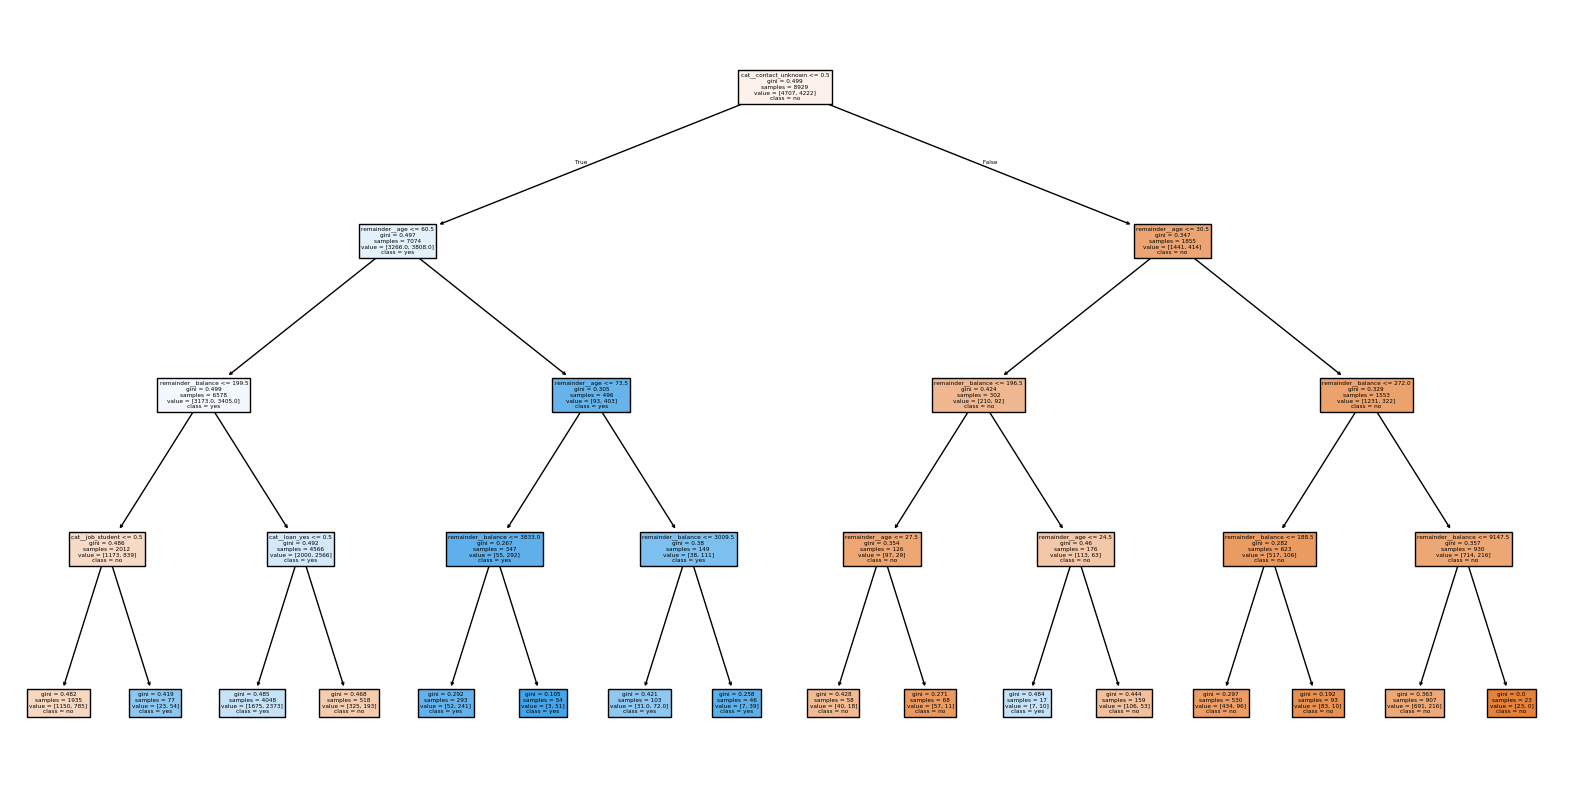

In [61]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

tree = dt_model.named_steps["classifier"]
feature_names = dt_model.named_steps["preprocess"].get_feature_names_out()

plt.figure(figsize=(20, 10))
plot_tree(
    tree,
    feature_names=feature_names,
    class_names=["no", "yes"],
    filled=True
)
plt.show()


In [62]:
from sklearn.tree import export_text

rules = export_text(tree, feature_names=list(feature_names))
print(rules)


|--- cat__contact_unknown <= 0.50
|   |--- remainder__age <= 60.50
|   |   |--- remainder__balance <= 199.50
|   |   |   |--- cat__job_student <= 0.50
|   |   |   |   |--- class: no
|   |   |   |--- cat__job_student >  0.50
|   |   |   |   |--- class: yes
|   |   |--- remainder__balance >  199.50
|   |   |   |--- cat__loan_yes <= 0.50
|   |   |   |   |--- class: yes
|   |   |   |--- cat__loan_yes >  0.50
|   |   |   |   |--- class: no
|   |--- remainder__age >  60.50
|   |   |--- remainder__age <= 73.50
|   |   |   |--- remainder__balance <= 3833.00
|   |   |   |   |--- class: yes
|   |   |   |--- remainder__balance >  3833.00
|   |   |   |   |--- class: yes
|   |   |--- remainder__age >  73.50
|   |   |   |--- remainder__balance <= 3009.50
|   |   |   |   |--- class: yes
|   |   |   |--- remainder__balance >  3009.50
|   |   |   |   |--- class: yes
|--- cat__contact_unknown >  0.50
|   |--- remainder__age <= 30.50
|   |   |--- remainder__balance <= 196.50
|   |   |   |--- remainder__a